In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions

In [ ]:
!pip install huggingface-hub

In [ ]:
!nvidia-smi

Mon Dec  4 02:30:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install libraries

!pip install diffusers
!pip install datasets
!pip install accelerate
!pip uninstall xformers
!pip install xformers==0.0.22
!pip install huggingface-hub
!huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
# imports

import argparse
import logging
import math
import os
import random
import shutil
import warnings
from pathlib import Path

import numpy as np
import PIL
import safetensors
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import create_repo, upload_folder

from packaging import version
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available


if is_wandb_available():
    import wandb

if version.parse(version.parse(PIL.__version__).base_version) >= version.parse("9.1.0"):
    PIL_INTERPOLATION = {
        "linear": PIL.Image.Resampling.BILINEAR,
        "bilinear": PIL.Image.Resampling.BILINEAR,
        "bicubic": PIL.Image.Resampling.BICUBIC,
        "lanczos": PIL.Image.Resampling.LANCZOS,
        "nearest": PIL.Image.Resampling.NEAREST,
    }
else:
    PIL_INTERPOLATION = {
        "linear": PIL.Image.LINEAR,
        "bilinear": PIL.Image.BILINEAR,
        "bicubic": PIL.Image.BICUBIC,
        "lanczos": PIL.Image.LANCZOS,
        "nearest": PIL.Image.NEAREST,
    }

from huggingface_hub import snapshot_download

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
# function to save to HuggingFace hub

def save_model_card(repo_id: str, images=None, base_model=str, repo_folder=None):
    img_str = ""
    for i, image in enumerate(images):
        image.save(os.path.join(repo_folder, f"image_{i}.png"))
        img_str += f"![img_{i}](./image_{i}.png)\n"

    yaml = f"""
---
license: creativeml-openrail-m
base_model: {base_model}
tags:
- stable-diffusion
- stable-diffusion-diffusers
- text-to-image
- diffusers
- textual_inversion
inference: true
---
    """
    model_card = f"""
# Textual inversion text2image fine-tuning - {repo_id}
These are textual inversion adaption weights for {base_model}. You can find some example images in the following. \n
{img_str}
"""
    with open(os.path.join(repo_folder, "README.md"), "w") as f:
        f.write(yaml + model_card)

In [ ]:
# function to run validation

def log_validation(text_encoder, tokenizer, unet, vae, variables_dict, accelerator, weight_dtype, epoch):
    logger.info(
        f"Running validation... \n Generating {variables_dict['num_validation_images']} images with prompt:"
        f" {variables_dict['validation_prompt']}."
    )
    # create pipeline (note: unet and vae are loaded again in float32)
    pipeline = DiffusionPipeline.from_pretrained(
        variables_dict['pretrained_model_name_or_path'],
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=unet,
        vae=vae,
        safety_checker=None,
        revision=variables_dict['revision'],
        variant=variables_dict['variant'],
        torch_dtype=weight_dtype,
    )
    pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    # run inference
    generator = None if variables_dict['seed'] is None else torch.Generator(device=accelerator.device).manual_seed(variables_dict['seed'])
    images = []
    for _ in range(variables_dict['num_validation_images']):
        with torch.autocast("cuda"):
            image = pipeline(variables_dict['validation_prompt'], num_inference_steps=25, generator=generator).images[0]
        images.append(image)

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("validation", np_images, epoch, dataformats="NHWC")
        if tracker.name == "wandb":
            tracker.log(
                {
                    "validation": [
                        wandb.Image(image, caption=f"{i}: {variables_dict['validation_prompt']}") for i, image in enumerate(images)
                    ]
                }
            )

    del pipeline
    torch.cuda.empty_cache()
    return images

In [ ]:
# save checkpoints while training
def save_progress(text_encoder, placeholder_token_ids, accelerator, variables_dict, save_path, safe_serialization=True):
    logger.info("Saving embeddings")
    learned_embeds = (
        accelerator.unwrap_model(text_encoder)
        .get_input_embeddings()
        .weight[min(placeholder_token_ids) : max(placeholder_token_ids) + 1]
    )
    learned_embeds_dict = {variables_dict['placeholder_token']: learned_embeds.detach().cpu()}

    if safe_serialization:
        safetensors.torch.save_file(learned_embeds_dict, save_path, metadata={"format": "pt"})
    else:
        torch.save(learned_embeds_dict, save_path)

In [1]:
# CONFIG VARIABLES

save_steps = 500 # Save learned embeddings every x steps
save_as_full_pipeline = True #Save the complete stable diffusion pipeline
num_vectors = 1 #How many textual inversion vectors shall be used to learn the concept TUNABLE
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5" #Path to pretrained model or model identifier from huggingface.co/models
revision = None
variant = None
tokenizer_name = None # Pretrained tokenizer name or path if not the same as model_name

# TO BE CHANGED FOR DIFFERENT DATASETS
local_dir = "./baseball"
snapshot_download("agangal/baseball-12-nocaptions", local_dir=local_dir, repo_type="dataset", ignore_patterns=".gitattributes")
train_data_dir = "./baseball" # directory for training data
placeholder_token = "<baseball-pitching>" # A token to use as a placeholder for the concept
initializer_token = "pitching"
validation_prompt = "A baseball player <baseball-pitching>"

learnable_property = "object" # Choose between 'object' and 'style'
repeats = 100 # How many times to repeat the training data
output_dir = "text-inversion-model-baseball" # output directory for model predictions and checkpoints
seed = None # seed for reproduction

resolution = 512
center_crop = True

train_batch_size = 1 # batch size per device for distributed training
num_train_epochs = 50 # adjust to 100 later
max_train_steps = 1000 # Total number of training steps to perform.  If provided, overrides num_train_epochs
gradient_accumulation_steps = 1 # Number of updates steps to accumulate before performing a backward/update pass
gradient_checkpointing = True # Whether or not to use gradient checkpointing, saving memory but slower

learning_rate = 5.0e-4 # initial learning rate
scale_lr = True # scale by number of GPUs/gradient accumulation steps
lr_scheduler = "constant" # The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial", "constant", "constant_with_warmup"]
lr_warmup_steps = 0
lr_num_cycles = 1 # Number of hard resets of the lr in cosine_with_restarts scheduler
dataloader_num_workers = 0 # Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process

adam_beta1 = 0.9
adam_beta2 = 0.999
adam_weight_decay = 1e-2
adam_epsilon = 1e-08
push_to_hub = True
hub_token = None #REMOVE THIS LATER
hub_model_id = None

logging_dir = "logs"
mixed_precision = "fp16" # "no", "fp16", "bf16"
allow_tf32 = True
report_to = "tensorboard"
num_validation_images = 4
validation_steps = 100
validation_epochs = None
local_rank = 1
checkpointing_steps = 500
checkpoints_total_limit = None
resume_from_checkpoint = None # Whether training should be resumed from a previous checkpoint. Use a path saved by
        # `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.

enable_xformers_memory_efficient_attention = True
no_safe_serialization = False

included_variables = [
    'save_steps', 'save_as_full_pipeline', 'num_vectors', 'pretrained_model_name_or_path', 'revision',
    'variant', 'tokenizer_name', 'local_dir', 'train_data_dir', 'placeholder_token', 'initializer_token',
    'validation_prompt', 'learnable_property', 'repeats', 'output_dir', 'seed', 'resolution', 'center_crop',
    'train_batch_size', 'num_train_epochs', 'max_train_steps', 'gradient_accumulation_steps',
    'gradient_checkpointing', 'learning_rate', 'scale_lr', 'lr_scheduler', 'lr_warmup_steps', 'lr_num_cycles',
    'dataloader_num_workers', 'adam_beta1', 'adam_beta2', 'adam_weight_decay', 'adam_epsilon', 'push_to_hub',
    'hub_token', 'hub_model_id', 'logging_dir', 'mixed_precision', 'allow_tf32', 'report_to',
    'num_validation_images', 'validation_steps', 'validation_epochs', 'local_rank', 'checkpointing_steps',
    'checkpoints_total_limit', 'resume_from_checkpoint', 'enable_xformers_memory_efficient_attention',
    'no_safe_serialization'
]

variables_dict = {var_name: globals()[var_name] for var_name in included_variables}

variables_dict



NameError: ignored

In [ ]:
# Prompt templates
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [ ]:
# Class for a textualinversiondataset from a regular dataset
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):
        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL_INTERPOLATION["linear"],
            "bilinear": PIL_INTERPOLATION["bilinear"],
            "bicubic": PIL_INTERPOLATION["bicubic"],
            "lanczos": PIL_INTERPOLATION["lanczos"],
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            (
                h,
                w,
            ) = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example


In [ ]:
# Logging and accelerator configuration
logger = get_logger(__name__)
logging_dir = os.path.join(output_dir, logging_dir)
accelerator_project_config = ProjectConfiguration(project_dir=output_dir, logging_dir=logging_dir)

accelerator = Accelerator(
    gradient_accumulation_steps=gradient_accumulation_steps,
    mixed_precision=mixed_precision,
    log_with=report_to,
    project_config=accelerator_project_config,
)

if report_to == "wandb":
    if not is_wandb_available():
        raise ImportError("Make sure to install wandb if you want to use it for logging during training.")

# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()


In [ ]:
# Training seed and save location
if seed is not None:
    set_seed(seed)

# Handle the repository creation
if accelerator.is_main_process:
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)

    if push_to_hub:
        repo_id = create_repo(
            repo_id=hub_model_id or Path(output_dir).name, exist_ok=True, token=hub_token
        ).repo_id


In [ ]:
# Load tokenizer
if tokenizer_name:
    tokenizer = CLIPTokenizer.from_pretrained(tokenizer_name)
elif pretrained_model_name_or_path:
    tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer")

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", revision=revision
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae", revision=revision, variant=variant
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", revision=revision, variant=variant
)


tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

{'clip_sample_range', 'variance_type', 'sample_max_value', 'thresholding', 'dynamic_thresholding_ratio', 'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.


text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

{'force_upcast', 'scaling_factor'} was not found in config. Values will be initialized to default values.


unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

{'timestep_post_act', 'attention_type', 'use_linear_projection', 'resnet_time_scale_shift', 'dual_cross_attention', 'projection_class_embeddings_input_dim', 'time_embedding_act_fn', 'num_attention_heads', 'only_cross_attention', 'time_cond_proj_dim', 'time_embedding_dim', 'class_embeddings_concat', 'conv_in_kernel', 'transformer_layers_per_block', 'addition_embed_type', 'upcast_attention', 'mid_block_type', 'encoder_hid_dim_type', 'resnet_skip_time_act', 'mid_block_only_cross_attention', 'time_embedding_type', 'resnet_out_scale_factor', 'addition_time_embed_dim', 'conv_out_kernel', 'reverse_transformer_layers_per_block', 'cross_attention_norm', 'encoder_hid_dim', 'dropout', 'num_class_embeds', 'class_embed_type', 'addition_embed_type_num_heads'} was not found in config. Values will be initialized to default values.


In [ ]:
# Add the placeholder token in tokenizer
placeholder_tokens = [placeholder_token]

if num_vectors < 1:
    raise ValueError(f"--num_vectors has to be larger or equal to 1, but is {num_vectors}")

# add dummy tokens for multi-vector
additional_tokens = []
for i in range(1, num_vectors):
    additional_tokens.append(f"{placeholder_token}_{i}")
placeholder_tokens += additional_tokens

num_added_tokens = tokenizer.add_tokens(placeholder_tokens)
if num_added_tokens != num_vectors:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [ ]:
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_ids = tokenizer.convert_tokens_to_ids(placeholder_tokens)

# Resize the token embeddings as we are adding new special tokens to the tokenizer
text_encoder.resize_token_embeddings(len(tokenizer))

# Initialise the newly added placeholder token with the embeddings of the initializer token
token_embeds = text_encoder.get_input_embeddings().weight.data
with torch.no_grad():
    for token_id in placeholder_token_ids:
        token_embeds[token_id] = token_embeds[initializer_token_id].clone()

In [ ]:
# Freeze vae and unet
vae.requires_grad_(False)
unet.requires_grad_(False)
# Freeze all parameters except for the token embeddings in text encoder
text_encoder.text_model.encoder.requires_grad_(False)
text_encoder.text_model.final_layer_norm.requires_grad_(False)
text_encoder.text_model.embeddings.position_embedding.requires_grad_(False)

if gradient_checkpointing:
    # Keep unet in train mode if we are using gradient checkpointing to save memory.
    # The dropout cannot be != 0 so it doesn't matter if we are in eval or train mode.
    unet.train()
    text_encoder.gradient_checkpointing_enable()
    unet.enable_gradient_checkpointing()

In [ ]:
if enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers
        print("Xformers is available")

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if scale_lr:
    learning_rate = (
        learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
    )

Xformers is available


In [ ]:
# Initialize the optimizer
optimizer = torch.optim.AdamW(
    text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

In [ ]:
# Dataset and DataLoaders creation:
train_dataset = TextualInversionDataset(
    data_root=train_data_dir,
    tokenizer=tokenizer,
    size=resolution,
    placeholder_token=(" ".join(tokenizer.convert_ids_to_tokens(placeholder_token_ids))),
    repeats=repeats,
    learnable_property=learnable_property,
    center_crop=center_crop,
    set="train",
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=dataloader_num_workers
)
if validation_epochs is not None:
    warnings.warn(
        f"FutureWarning: You are doing logging with validation_epochs={validation_epochs}."
        " Deprecated validation_epochs in favor of `validation_steps`"
        f"Setting `validation_steps` to {validation_epochs * len(train_dataset)}",
        FutureWarning,
        stacklevel=2,
    )
    validation_steps = validation_epochs * len(train_dataset)

In [ ]:
# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
if max_train_steps is None:
    max_train_steps = num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps * accelerator.num_processes,
    num_training_steps=max_train_steps * accelerator.num_processes,
    num_cycles=lr_num_cycles,
)

In [ ]:
text_encoder.train()
# Prepare everything with our `accelerator`.
text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    text_encoder, optimizer, train_dataloader, lr_scheduler
)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

In [ ]:
# Move vae and unet to device and cast to weight_dtype
unet.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
if overrode_max_train_steps:
    max_train_steps = num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    accelerator.init_trackers("textual_inversion", config=variables_dict)

In [ ]:
# Train!
# setup logger, check for resuming checkpoing
total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {max_train_steps}")
global_step = 0
first_epoch = 0
# Potentially load in the weights and states from a previous save
if resume_from_checkpoint:
    if resume_from_checkpoint != "latest":
        path = os.path.basename(resume_from_checkpoint)
    else:
        # Get the most recent checkpoint
        dirs = os.listdir(output_dir)
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1] if len(dirs) > 0 else None

    if path is None:
        accelerator.print(
            f"Checkpoint '{resume_from_checkpoint}' does not exist. Starting a new training run."
        )
        resume_from_checkpoint = None
        initial_global_step = 0
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(os.path.join(output_dir, path))
        global_step = int(path.split("-")[1])

        initial_global_step = global_step
        first_epoch = global_step // num_update_steps_per_epoch

else:
    initial_global_step = 0

In [ ]:
progress_bar = tqdm(
    range(0, max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # Only show the progress bar once on each machine.
    disable=not accelerator.is_local_main_process,
)

# keep original embeddings as reference
orig_embeds_params = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight.data.clone()

for epoch in range(first_epoch, num_train_epochs):
    text_encoder.train()
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(text_encoder):
            # Convert images to latent space
            latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
            latents = latents * vae.config.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])[0].to(dtype=weight_dtype)

            # Predict the noise residual
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Let's make sure we don't update any embedding weights besides the newly added token
            index_no_updates = torch.ones((len(tokenizer),), dtype=torch.bool)
            index_no_updates[min(placeholder_token_ids) : max(placeholder_token_ids) + 1] = False

            with torch.no_grad():
                accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[
                    index_no_updates
                ] = orig_embeds_params[index_no_updates]

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            images = []
            progress_bar.update(1)
            global_step += 1
            if global_step % save_steps == 0:
                weight_name = (
                    f"learned_embeds-steps-{global_step}.bin"
                    if no_safe_serialization
                    else f"learned_embeds-steps-{global_step}.safetensors"
                )
                save_path = os.path.join(output_dir, weight_name)
                save_progress(
                    text_encoder,
                    placeholder_token_ids,
                    accelerator,
                    variables_dict,
                    save_path,
                    safe_serialization=not no_safe_serialization,
                )

            if accelerator.is_main_process:
                if global_step % checkpointing_steps == 0:
                    # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                    if checkpoints_total_limit is not None:
                        checkpoints = os.listdir(output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                        if len(checkpoints) >= checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(
                                f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                            )
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

                if validation_prompt is not None and global_step % validation_steps == 0:
                    images = log_validation(
                        text_encoder, tokenizer, unet, vae, variables_dict, accelerator, weight_dtype, epoch
                    )

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= max_train_steps:
            break



Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

{'image_encoder', 'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'solver_type', 'lambda_

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'solver_type', 'lambda_

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'solver_type', 'lambda_

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'solver_type', 'lambda_

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'solver_type', 'lambda_

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'solver_type', 'lambda_

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'solver_type', 'lambda_

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'solver_type', 'lambda_

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'solver_type', 'lambda_

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'solver_type', 'lambda_

In [ ]:
# Create the pipeline using the trained modules and save it.
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    if push_to_hub and not save_as_full_pipeline:
        logger.warn("Enabling full model saving because --push_to_hub=True was specified.")
        save_full_model = True
    else:
        save_full_model = save_as_full_pipeline
    if save_full_model:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=tokenizer,
        )
        pipeline.save_pretrained(output_dir)
    # Save the newly trained embeddings
    weight_name = "learned_embeds.bin" if no_safe_serialization else "learned_embeds.safetensors"
    save_path = os.path.join(output_dir, weight_name)
    save_progress(
        text_encoder,
        placeholder_token_ids,
        accelerator,
        variables_dict,
        save_path,
        safe_serialization=not no_safe_serialization,
    )

    if push_to_hub:
        save_model_card(
            repo_id,
            images=images,
            base_model=pretrained_model_name_or_path,
            repo_folder=output_dir,
        )
        upload_folder(
            repo_id=repo_id,
            folder_path=output_dir,
            commit_message="End of training",
            ignore_patterns=["step_*", "epoch_*"],
        )

accelerator.end_training()

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

{'image_encoder', 'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
Configuration saved in text-inversion-model-baseball/vae/config.json
Model weights saved in text-inversion-model-baseball/vae/diffusion_

random_states_0.pkl:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/304M [00:00<?, ?B/s]

Upload 19 LFS files:   0%|          | 0/19 [00:00<?, ?it/s]

scaler.pt:   0%|          | 0.00/557 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/563 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/304M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/557 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/563 [00:00<?, ?B/s]

learned_embeds.safetensors:   0%|          | 0.00/3.19k [00:00<?, ?B/s]

learned_embeds-steps-500.safetensors:   0%|          | 0.00/3.19k [00:00<?, ?B/s]

learned_embeds.safetensors:   0%|          | 0.00/3.19k [00:00<?, ?B/s]

events.out.tfevents.1701657526.5c2fdd6622c9.1229.1:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

events.out.tfevents.1701657526.5c2fdd6622c9.1229.0:   0%|          | 0.00/16.0M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

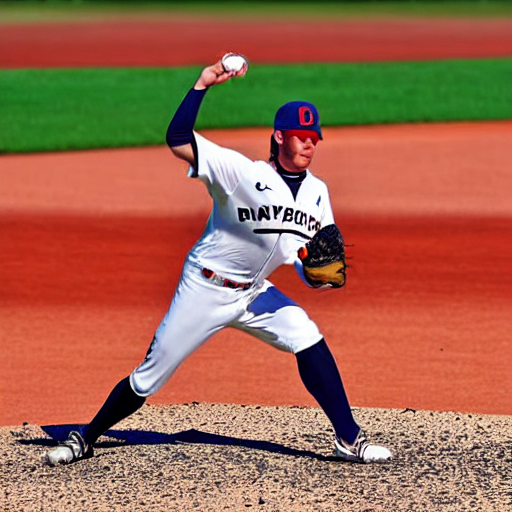

In [ ]:
display(images[2])